In [ ]:
# # ============================================
# # Galaxy10 -> 4-clase CNN en PyTorch (3k samples, 128x128)
# # Entrena en GPU si está disponible y guarda el modelo
# # ============================================

# import os
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from tqdm.auto import trange

# # -----------------------
# # 1) Configuración básica
# # -----------------------
# H5_PATH = "Galaxy10_DECals.h5"   # <-- ajusta si está en otra ruta
# N_SUB   = 3500                   # maximo de galaxias a usar
# IMG_SIZE = 128                   # resolucion a la que reducimos

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Usando device:", device)

# # -----------------------
# # 2) Cargar dataset HDF5
# # -----------------------
# with h5py.File(H5_PATH, "r") as f:
#     imgs_ds   = f["images"][:]   # (N,256,256,3) uint8
#     labels_ds = f["ans"][:]      # (N,)
    
# print("Imagenes totales:", imgs_ds.shape)
# print("Etiquetas totales:", labels_ds.shape)

# # ------------------------------------------------
# # 3) Mapear clases originales -> 4 clases finales
# # ------------------------------------------------
# # Definimos el mapeo:
# # 0: Disturbed -> 0: Irregular
# # 2: Round Smooth -> 1: Eliptica
# # 3: In-between Round Smooth -> 1: Eliptica
# # 5: Barred Spiral -> 2: Espiral barrada
# # 6: Unbarred Tight Spiral -> 3: Espiral sin barra
# # 7: Unbarred Loose Spiral -> 3: Espiral sin barra

# orig_to_new = {
#     0: 0,
#     2: 1,
#     3: 1,
#     5: 2,
#     6: 3,
#     7: 3,
# }

# valid_orig_classes = np.array(list(orig_to_new.keys()))
# mask = np.isin(labels_ds, valid_orig_classes)

# imgs_valid   = imgs_ds[mask]
# labels_valid = labels_ds[mask]

# labels_4 = np.array([orig_to_new[int(c)] for c in labels_valid])

# print("Despues del filtrado por clases:")
# print("imgs_valid:", imgs_valid.shape)
# print("labels_4 shape:", labels_4.shape)
# print("Distribucion 4 clases:", np.bincount(labels_4))

# # --------------------------
# # 4) Submuestreo a 3000 max
# # --------------------------
# N_total = imgs_valid.shape[0]
# N_use = min(N_SUB, N_total)
# idx_all = np.arange(N_total)
# np.random.shuffle(idx_all)
# idx_sel = idx_all[:N_use]
# idx_sel.sort()

# images_sub = imgs_valid[idx_sel]
# labels_sub = labels_4[idx_sel]

# print(f"Usando {N_use} galaxias para el entrenamiento")
# print("images_sub:", images_sub.shape)
# print("labels_sub:", labels_sub.shape)
# print("Distribucion subset:", np.bincount(labels_sub))

# # ---------------------------------------------
# # 5) Preprocesamiento: normalizar y resize 128x128
# # ---------------------------------------------
# # De uint8 [0,255] a float32 [0,1]
# images_sub = images_sub.astype("float32") / 255.0

# # A tensor (N,3,256,256)
# imgs_tensor = torch.from_numpy(images_sub).permute(0,3,1,2)  # CHW

# # Resize a 128x128
# imgs_small = F.interpolate(
#     imgs_tensor,
#     size=(IMG_SIZE, IMG_SIZE),
#     mode="bilinear",
#     align_corners=False
# ).numpy()  # de regreso a numpy (N,3,128,128)

# X = imgs_small
# y = labels_sub

# print("X final:", X.shape)  # (N_use,3,128,128)
# print("y final:", y.shape)

# # -----------------------------------
# # 6) Split train / val / test (80/20)
# # -----------------------------------
# idx_all = np.arange(X.shape[0])

# idx_learn, idx_test = train_test_split(
#     idx_all, train_size=0.8, test_size=0.2,
#     random_state=42, stratify=y
# )

# X_learn, y_learn = X[idx_learn], y[idx_learn]
# X_test,  y_test  = X[idx_test],  y[idx_test]

# # Split interno train / val (70/30 de learn)
# idx_train, idx_val = train_test_split(
#     np.arange(X_learn.shape[0]),
#     train_size=0.7, test_size=0.3,
#     random_state=42, stratify=y_learn
# )

# X_train, y_train = X_learn[idx_train], y_learn[idx_train]
# X_val,   y_val   = X_learn[idx_val],   y_learn[idx_val]

# print("Train:", X_train.shape, y_train.shape)
# print("Val:  ", X_val.shape,   y_val.shape)
# print("Test: ", X_test.shape,  y_test.shape)

# # ------------------------
# # 7) Dataset y DataLoader
# # ------------------------
# class GalaxyDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.from_numpy(X).float()    # (N,3,128,128)
#         self.y = torch.from_numpy(y).long()     # (N,)
#     def __len__(self):
#         return self.X.shape[0]
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# train_ds = GalaxyDataset(X_train, y_train)
# val_ds   = GalaxyDataset(X_val,   y_val)
# test_ds  = GalaxyDataset(X_test,  y_test)

# BATCH_TRAIN = 64
# BATCH_EVAL  = 128

# train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL,  shuffle=False, num_workers=2, pin_memory=True)
# test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False, num_workers=2, pin_memory=True)

# # ------------------------
# # 8) Definir la CNN en PyTorch
# # ------------------------
# class GalaxyCNN(nn.Module):
#     def __init__(self, num_classes=4):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 64x64

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 32x32

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 16x16

#             nn.Dropout(0.5),
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256*16*16, 150),
#             nn.Tanh(),
#             nn.Dropout(0.3),
#             nn.Linear(150, 60),
#             nn.Tanh(),
#             nn.Dropout(0.3),
#             nn.Linear(60, num_classes)
#         )
#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# model = GalaxyCNN(num_classes=4).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=1e-3,
#     weight_decay=1e-3   # regularizacion L2 (similar a kernel_regularizer)
# )

# print(model)

# # ------------------------
# # 9) Entrenamiento
# # ------------------------
# def run_epoch(loader, train=True):
#     if train:
#         model.train()
#     else:
#         model.eval()
#     running_loss, correct, total = 0.0, 0, 0

#     for Xb, yb in loader:
#         Xb, yb = Xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

#         if train:
#             optimizer.zero_grad()

#         with torch.set_grad_enabled(train):
#             logits = model(Xb)
#             loss = criterion(logits, yb)
#             if train:
#                 loss.backward()
#                 optimizer.step()

#         running_loss += loss.item() * Xb.size(0)
#         preds = logits.argmax(dim=1)
#         correct += (preds == yb).sum().item()
#         total   += yb.size(0)

#     return running_loss/total, correct/total

# EPOCHS = 15

# best_val_acc = 0.0
# best_state   = None

# for epoch in trange(1, EPOCHS+1, desc="Entrenando"):
#     train_loss, train_acc = run_epoch(train_loader, train=True)
#     val_loss,   val_acc   = run_epoch(val_loader,   train=False)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_state   = model.state_dict()

#     print(
#         f"Epoch {epoch:02d} | "
#         f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
#         f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
#     )

# # Restaurar mejor modelo segun val_acc
# if best_state is not None:
#     model.load_state_dict(best_state)
#     print(f"Restaurando mejor modelo (val_acc = {best_val_acc:.3f})")

# # ------------------------
# # 10) Evaluacion en test
# # ------------------------
# model.eval()
# test_loss, test_acc = run_epoch(test_loader, train=False)
# print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

# # ------------------------
# # 11) Guardar el modelo
# # ------------------------
# SAVE_PATH = "galaxy_cnn_4cls_1.pt"
# torch.save(model.state_dict(), SAVE_PATH)
# print(f"Modelo guardado en: {SAVE_PATH}")


/home/kingsman/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando device: cuda
Imagenes totales: (17736, 256, 256, 3)
Etiquetas totales: (17736,)
Despues del filtrado por clases:
imgs_valid: (12253, 256, 256, 3)
labels_4 shape: (12253,)
Distribucion 4 clases: [1081 4672 2043 4457]
Usando 3500 galaxias para el entrenamiento
images_sub: (3500, 256, 256, 3)
labels_sub: (3500,)
Distribucion subset: [ 317 1339  564 1280]
X final: (3500, 3, 128, 128)
y final: (3500,)
Train: (1959, 3, 128, 128) (1959,)
Val:   (840, 3, 128, 128) (840,)
Test:  (700, 3, 128, 128) (700,)
GalaxyCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2

Entrenando:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# # ============================================
# # Demo para la Noche de las Estrellas
# # Cargar modelo entrenado (PyTorch) + Galaxy10
# # y mostrar galaxias con predicción de la IA
# # ============================================

# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotx
# plt.style.use(matplotx.styles.dracula)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # -----------------------
# # 1) Dispositivo (CPU/GPU)
# # -----------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Usando device:", device)

# # -----------------------
# # 2) Definir la CNN (misma arquitectura)
# # -----------------------
# class GalaxyCNN(nn.Module):
#     def __init__(self, num_classes=4):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 64x64

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 32x32

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),   # 16x16

#             nn.Dropout(0.5),
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256*16*16, 150),
#             nn.Tanh(),
#             nn.Dropout(0.3),
#             nn.Linear(150, 60),
#             nn.Tanh(),
#             nn.Dropout(0.3),
#             nn.Linear(60, num_classes)
#         )
#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# # Instanciar modelo y cargar pesos
# model = GalaxyCNN(num_classes=4).to(device)
# state_dict = torch.load("galaxy_cnn_4cls.pt", map_location=device)
# model.load_state_dict(state_dict)
# model.eval()
# print("Modelo cargado correctamente.")

# # -----------------------
# # 3) Cargar dataset Galaxy10 local
# # -----------------------
# H5_PATH = "Galaxy10_DECals.h5"  # ajusta si esta en otra ruta

# with h5py.File(H5_PATH, "r") as f:
#     imgs_all   = f["images"][:]  # (N,256,256,3), uint8
#     labels_all = f["ans"][:]     # (N,)

# print("Total imgs en archivo:", imgs_all.shape)
# print("Total labels:", labels_all.shape)

# # -----------------------
# # 4) Mapear a las 4 clases
# # -----------------------
# # Mapeo original -> 4 clases:
# # 0: Disturbed               -> 0: Irregular
# # 2: Round Smooth            -> 1: Eliptica
# # 3: In-between Round Smooth -> 1: Eliptica
# # 5: Barred Spiral           -> 2: Espiral barrada
# # 6: Unbarred Tight Spiral   -> 3: Espiral sin barra
# # 7: Unbarred Loose Spiral   -> 3: Espiral sin barra

# orig_to_new = {
#     0: 0,
#     2: 1,
#     3: 1,
#     5: 2,
#     6: 3,
#     7: 3,
# }

# valid_orig_classes = np.array(list(orig_to_new.keys()))
# mask = np.isin(labels_all, valid_orig_classes)

# imgs_valid   = imgs_all[mask]         # (N_valid,256,256,3)
# labels_valid = labels_all[mask]       # (N_valid,)

# labels_4 = np.array([orig_to_new[int(c)] for c in labels_valid])

# print("Despues de filtrar clases validas:")
# print("imgs_valid:", imgs_valid.shape)
# print("labels_4:", labels_4.shape)
# print("Distribucion 4 clases:", np.bincount(labels_4))

# # -----------------------
# # 5) Preprocesar para la red
# # -----------------------
# # Normalizar [0,255] -> [0,1]
# imgs_norm = imgs_valid.astype("float32") / 255.0   # (N,256,256,3)

# # A tensor CHW
# X_t = torch.from_numpy(imgs_norm).permute(0,3,1,2)   # (N,3,256,256)

# # Resize a 128x128 (como en el entrenamiento)
# X_t = F.interpolate(
#     X_t,
#     size=(128,128),
#     mode="bilinear",
#     align_corners=False
# )

# # Pasamos a device solo al volar, para no saturar GPU
# print("Tensor de entrada para la red:", X_t.shape)

# # Nombres de clases para la demo
# names_4 = ["Irregular", "Eliptica", "Espiral barrada", "Espiral sin barra"]

# # -----------------------
# # 6) Funcion de demo
# # -----------------------
# def show_random_prediction(show_true=True):
#     """
#     Elige una galaxia al azar, la muestra y enseña:
#     - Prediccion de la IA
#     - Probabilidades por clase
#     - (Opcional) Etiqueta verdadera
#     """
#     model.eval()
#     N = X_t.shape[0]
#     i = np.random.randint(0, N)

#     # Imagen para la red (128x128) y para mostrar (256x256 original)
#     x_img = X_t[i:i+1].to(device)          # (1,3,128,128)
#     img_disp = imgs_norm[i]               # (256,256,3)
#     true_class = labels_4[i]

#     with torch.no_grad():
#         logits = model(x_img)             # (1,4)
#         proba  = torch.softmax(logits, dim=1)[0].cpu().numpy()
#         k_pred = int(np.argmax(proba))

#     # Mostrar imagen
#     plt.figure(figsize=(4,4))
#     plt.imshow(img_disp)
#     plt.axis("off")

#     title = f"IA dice: {names_4[k_pred]}\n"
#     title += " | ".join(f"{names_4[j]}={proba[j]:.2f}" for j in range(4))
#     if show_true:
#         title += f"\nClase real: {names_4[true_class]}"
#     plt.title(title, fontsize=10)
#     plt.tight_layout()
#     plt.show()

#     # Para que tambien puedas ver numericamente en consola, si quieres
#     print(f"Prediccion: {names_4[k_pred]} (proba={proba[k_pred]:.3f})")
#     print(f"Clase real: {names_4[true_class]}")
#     print("Probs:", {names_4[j]: float(f"{proba[j]:.3f}") for j in range(4)})

# # -----------------------
# # 7) Como usar en la actividad
# # -----------------------
# # Cada vez que llames:
# # show_random_prediction()
# # saldra una galaxia nueva con la prediccion de la IA.


Usando device: cuda
Modelo cargado correctamente.
Total imgs en archivo: (17736, 256, 256, 3)
Total labels: (17736,)
Despues de filtrar clases validas:
imgs_valid: (12253, 256, 256, 3)
labels_4: (12253,)
Distribucion 4 clases: [1081 4672 2043 4457]


In [1]:
# ============================================
# Demo para la Noche de las Estrellas
# Cargar modelo entrenado (PyTorch) + SUBSET de Galaxy10
# y mostrar galaxias con predicción de la IA
# ============================================

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotx
plt.style.use(matplotx.styles.dracula)

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------
# 0) Parámetros
# -----------------------
H5_PATH = "Galaxy10_DECals.h5"   # Ruta al archivo
MODEL_PATH = "galaxy_cnn_4cls.pt"
N_DEMO = 200                     # numero de galaxias a cargar para la demo
IMG_SIZE = 128                   # tamaño para la red

# -----------------------
# 1) Dispositivo (CPU/GPU)
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# -----------------------
# 2) Definir la CNN (misma arquitectura)
# -----------------------
class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 64x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16

            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*16*16, 150),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(150, 60),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(60, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instanciar modelo y cargar pesos
model = GalaxyCNN(num_classes=4).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Modelo cargado correctamente.")

# -----------------------
# 3) Cargar SOLO labels y elegir subset
# -----------------------
with h5py.File(H5_PATH, "r") as f:
    labels_all = f["ans"][:]     # (N,)
    N_total = labels_all.shape[0]
    print("Total labels en archivo:", N_total)

# Mapeo original -> 4 clases:
# 0: Disturbed               -> 0: Irregular
# 2: Round Smooth            -> 1: Eliptica
# 3: In-between Round Smooth -> 1: Eliptica
# 5: Barred Spiral           -> 2: Espiral barrada
# 6: Unbarred Tight Spiral   -> 3: Espiral sin barra
# 7: Unbarred Loose Spiral   -> 3: Espiral sin barra

orig_to_new = {
    0: 0,
    2: 1,
    3: 1,
    5: 2,
    6: 3,
    7: 3,
}

valid_orig_classes = np.array(list(orig_to_new.keys()))
mask_valid = np.isin(labels_all, valid_orig_classes)

idx_valid = np.where(mask_valid)[0]   # índices de las clases que nos interesan
N_valid = idx_valid.shape[0]
print("N validas (clases 0,2,3,5,6,7):", N_valid)

# Elegimos un subset aleatorio de esas validas
N_use = min(N_DEMO, N_valid)
idx_subset = np.random.choice(idx_valid, size=N_use, replace=False)
idx_subset.sort()

# Ahora sí, cargamos solo esas imágenes
with h5py.File(H5_PATH, "r") as f:
    imgs_sub = f["images"][idx_subset]   # (N_use,256,256,3) uint8
labels_sub_orig = labels_all[idx_subset]
labels_4 = np.array([orig_to_new[int(c)] for c in labels_sub_orig])

print(f"Usando {N_use} galaxias para la demo")
print("imgs_sub:", imgs_sub.shape)
print("labels_4:", labels_4.shape)
print("Distribucion 4 clases subset:", np.bincount(labels_4))

# -----------------------
# 4) Preprocesar para la red
# -----------------------
# Normalizar [0,255] -> [0,1]
imgs_norm = imgs_sub.astype("float32") / 255.0   # (N_use,256,256,3)

# A tensor CHW
X_t = torch.from_numpy(imgs_norm).permute(0,3,1,2)   # (N_use,3,256,256)

# Resize a 128x128 (como en el entrenamiento)
X_t = F.interpolate(
    X_t,
    size=(IMG_SIZE, IMG_SIZE),
    mode="bilinear",
    align_corners=False
)

print("Tensor de entrada para la red:", X_t.shape)  # (N_use,3,128,128)

# Nombres de clases para la demo
names_4 = ["Irregular", "Eliptica", "Espiral barrada", "Espiral sin barra"]

# =======================
# ============================================
# Funciones para la dinámica en 3 pasos
# ============================================

LAST_INDEX = None
LAST_PROBA = None
LAST_PRED  = None


# =====================================================
# 1) MOSTRAR SOLO LA IMAGEN (para el público)
# =====================================================
def show_image_only():
    """
    Muestra una galaxia aleatoria en GRANDE.
    No imprime prediccion ni clase real.
    Solo guarda el indice para usarlo en los pasos 2 y 3.
    """
    global LAST_INDEX, LAST_PROBA, LAST_PRED

    model.eval()
    N = X_t.shape[0]
    i = np.random.randint(0, N)

    LAST_INDEX = i
    LAST_PROBA = None
    LAST_PRED = None

    img_disp = imgs_norm[i]   # (256,256,3)

    plt.figure(figsize=(8,8))
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("¿Qué tipo de galaxia es?", fontsize=20)
    plt.tight_layout()
    plt.show()

    print(f"[IMAGEN] Se mostró la galaxia #{i}. Esperando predicciones del público...")


# =====================================================
# 2) MOSTRAR SOLO LA PREDICCIÓN DE LA IA
# =====================================================
def show_ai_prediction():
    """
    Usa la ultima imagen mostrada y SOLO imprime:
      - Prediccion de la IA
      - Probabilidades
    NO muestra la clase real.
    """
    global LAST_INDEX, LAST_PROBA, LAST_PRED

    if LAST_INDEX is None:
        print("Primero usa show_image_only()")
        return

    i = LAST_INDEX
    x_img = X_t[i:i+1].to(device)

    with torch.no_grad():
        logits = model(x_img)
        proba  = torch.softmax(logits, dim=1)[0].cpu().numpy()
        k_pred = int(np.argmax(proba))

    LAST_PROBA = proba
    LAST_PRED  = k_pred

    print("\n=== PREDICCION DE LA IA ===")
    print(f"IA dice: {names_4[k_pred]}")
    print("Probabilidades:")
    for j in range(4):
        print(f"  {names_4[j]}: {proba[j]:.3f}")


# =====================================================
# 3) MOSTRAR LA CLASE REAL + SI LA IA ACERTÓ
# =====================================================
def reveal_real_class():
    """
    Usa la imagen mostrada y revela:
      - Clase real
      - Si la IA acerto
    """
    if LAST_INDEX is None:
        print("Primero muestra una imagen con show_image_only().")
        return

    if LAST_PRED is None:
        print("Primero muestra la prediccion de la IA con show_ai_prediction().")
        return

    i = LAST_INDEX
    true_class = labels_4[i]
    k_pred = LAST_PRED

    print("\n=== CLASE REAL ===")
    print(f"Clase REAL:     {names_4[true_class]}")
    print(f"Prediccion IA:  {names_4[k_pred]}")
    print(f"¿Acertó la IA?: {'SI ✅' if k_pred == true_class else 'NO ❌'}")


# =======================
# 8) Panel de referencia (un ejemplo x clase)
# =======================
def show_reference_panel():
    """
    Muestra 1 ejemplo por clase (4 clases),
    para usar como imagen fija de referencia.
    """
    # indices por clase
    indices_por_clase = {c: np.where(labels_4 == c)[0] for c in range(4)}

    example_indices = []
    for c in range(4):
        arr = indices_por_clase[c]
        if len(arr) == 0:
            print(f"No hay ejemplos para clase {names_4[c]}")
            return
        example_indices.append(np.random.choice(arr))

    # Plot
    plt.figure(figsize=(18,8))
    for j, idx in enumerate(example_indices):
        img = imgs_norm[idx]
        plt.subplot(1,4,j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(names_4[j], fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Indices mostrados:", example_indices)



Usando device: cuda
Modelo cargado correctamente.
Total labels en archivo: 17736
N validas (clases 0,2,3,5,6,7): 12253
Usando 200 galaxias para la demo
imgs_sub: (200, 256, 256, 3)
labels_4: (200,)
Distribucion 4 clases subset: [14 66 37 83]
Tensor de entrada para la red: torch.Size([200, 3, 128, 128])


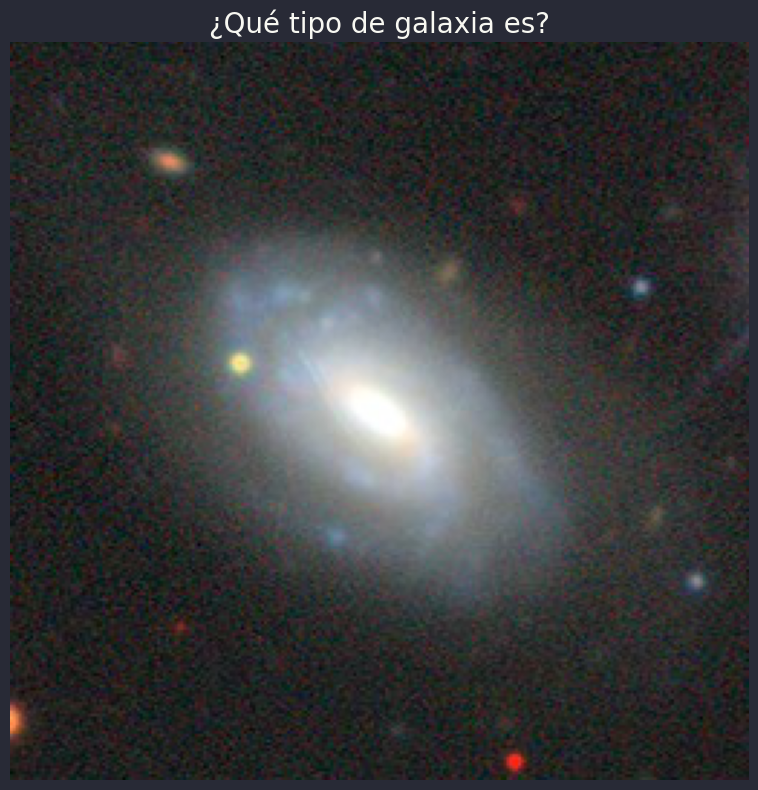

[IMAGEN] Se mostró la galaxia #82. Esperando predicciones del público...


In [7]:
show_image_only()


In [8]:
show_ai_prediction()



=== PREDICCION DE LA IA ===
IA dice: Espiral sin barra
Probabilidades:
  Irregular: 0.038
  Eliptica: 0.019
  Espiral barrada: 0.323
  Espiral sin barra: 0.620


In [9]:
reveal_real_class()



=== CLASE REAL ===
Clase REAL:     Espiral barrada
Prediccion IA:  Espiral sin barra
¿Acertó la IA?: NO ❌


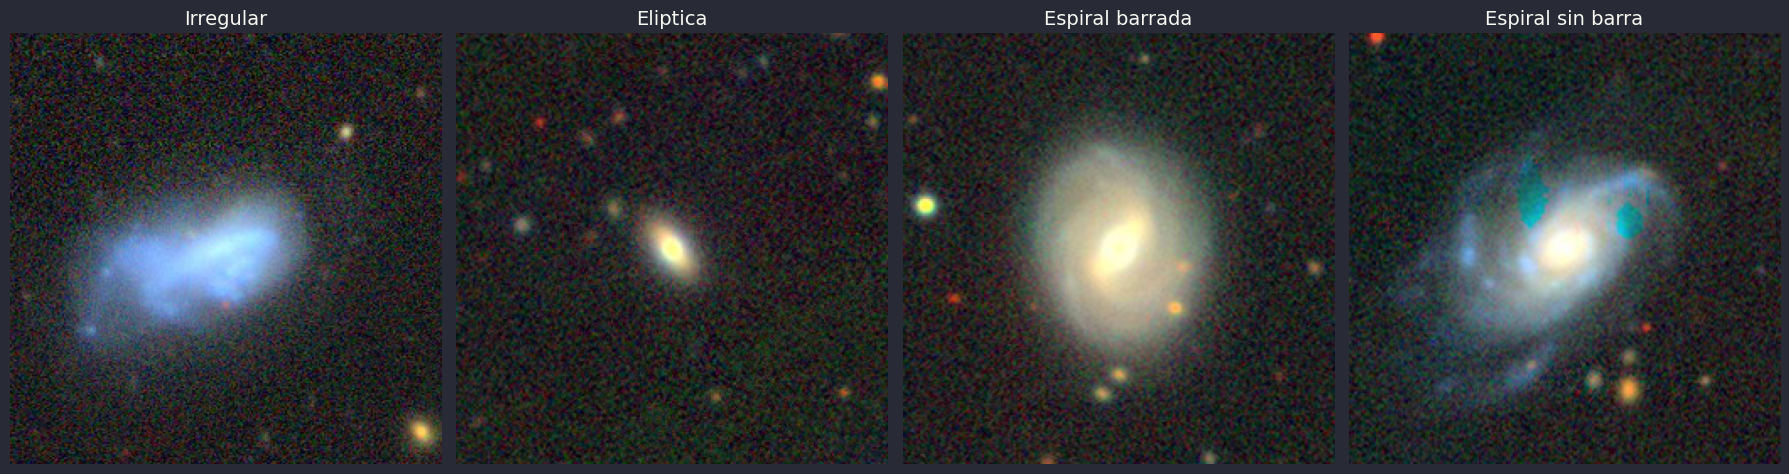

Indices mostrados: [18, 78, 105, 168]


In [35]:
show_reference_panel()
